# Loading data 

In [ ]:
from collections import defaultdict
import random
import torch
from torch import Tensor
import torch.nn as nn
from typing import Iterable, Tuple, Any, List, Optional
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import numpy.typing as npt

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Verification qu'un cpu est disponible
print(f"Utilisation de {device}")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
num_per_class = 10  # 10 images par classe pour un total de 100 images équilibrées
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # Charger les données MNIST
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True) # Charger les données MNIST
class_indices = defaultdict(list) # Grouper les indices par classe
for idx, (image, label) in enumerate(train_dataset):
    class_indices[label].append(idx)
balanced_indices = [] # Sélectionner aléatoirement des indices équilibrés
for label, indices in class_indices.items():
    balanced_indices.extend(random.sample(indices, num_per_class))
labeled_dataset = Subset(train_dataset, balanced_indices) # Créer un dataset équilibré avec les indices sélectionnés
labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True) # Créer les DataLoaders
unlabeled_indices = list(set(range(len(train_dataset))) - set(balanced_indices))
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
balanced_labels = [train_dataset[i][1] for i in balanced_indices] # Vérifier la répartition des classes dans le dataset équilibré


Utilisation de cuda


In [16]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

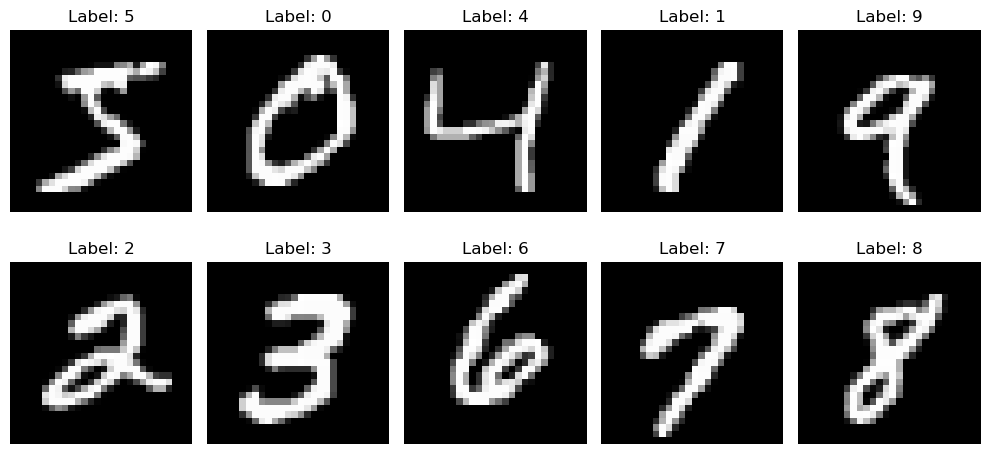

In [17]:
def show_one_image_per_label(
    dataset: Iterable[Tuple[Any, int]]
)->None:
    """Affiche une image pour chaque étiquette (de 0 à 9) à partir d'un dataset.

    Args:
        None: Affiche une grille de 10 images, une par label.
    """
    labels_seen = set()
    images_to_show = []
    for image, label in dataset:
        if label not in labels_seen:
            images_to_show.append(
                (image,label)
                )
            labels_seen.add(
                label
                )
        if len(
            labels_seen
            ) == 10:
            break
    plt.figure(
        figsize=(10, 5)
        )
    for i, (image, label) in enumerate(images_to_show):
        plt.subplot(2,
                    5,
                    i + 1
                    )
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_one_image_per_label(train_dataset)


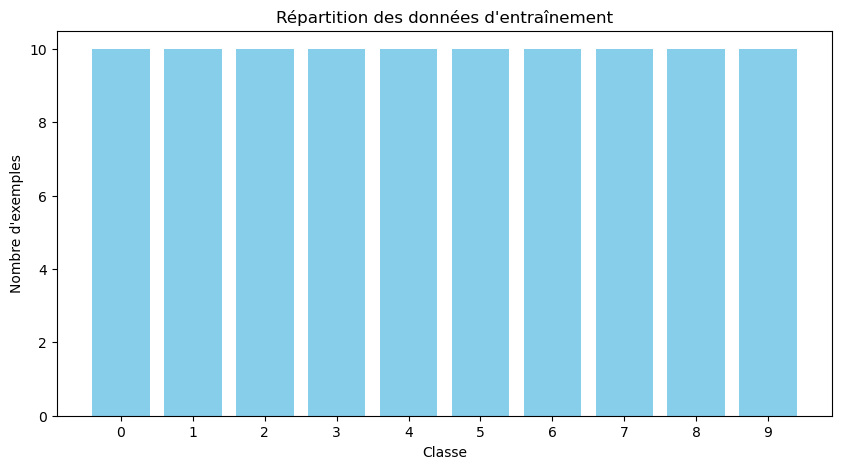

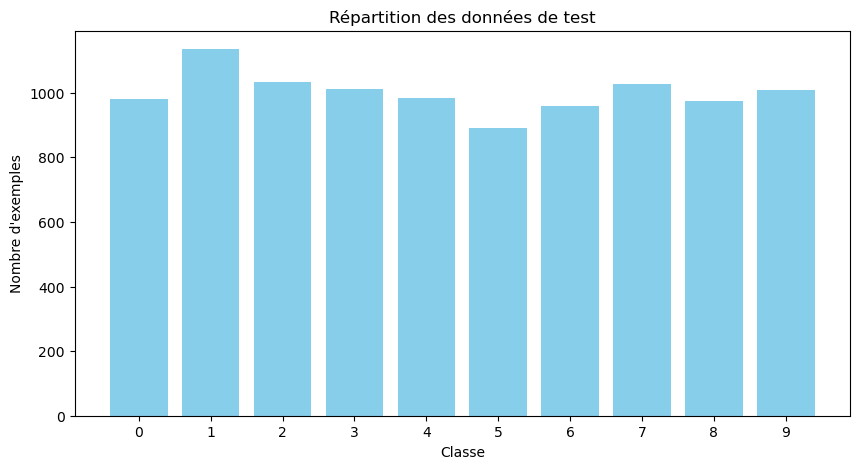

In [18]:
def plot_data_distribution(
    dataset: List[Tuple[np.ndarray, int]],
    title: str="Répartition des données",
)->None:
    """Affiche un histogramme représentant la répartition des classes dans un dataset.

    Args:
        dataset : List[Tuple[np.ndarray, int]]: Liste de paires (image, label), les images étant des tableaux numpy.
        title (str, optional): Titre du graphique (par défaut "Répartition des données").
    """
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(
        label_counts.keys(),
        label_counts.values(),
        color='skyblue'
        )
    plt.title(title)
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'exemples")
    plt.xticks(range(10))  # MNIST a 10 classes
    plt.show()

plot_data_distribution(labeled_dataset, title="Répartition des données d'entraînement") # Répartition pour l'ensemble d'entraînement
plot_data_distribution(test_dataset, title="Répartition des données de test") # Répartition pour l'ensemble de test


# Définition du Modèle

# modéle 1

In [19]:
class SimpleCNNWithDropout(nn.Module):
    """ Réseau de neurones convolutionnel simple avec dropout.

    Architecture :
    - 2 couches convolutionnelles (Conv2d) avec ReLU et MaxPool2d
    - Dropout après chaque bloc convolutionnel
    - 2 couches entièrement connectées (Linear)
    - Dropout entre les couches fully connected

    Conçu pour des images MNIST (1 canal, 28x28).
    """
    def __init__(self)->None:
        super(SimpleCNNWithDropout, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        # Dropout
        self.dropout1 = nn.Dropout(0.25)  # Dropout après les couches convolutives
        self.dropout2 = nn.Dropout(0.5)  # Dropout après la première couche entièrement connectée

    def forward(self, x: Tensor)->Tensor:
        """Effectue la propagation avant du réseau.

        Args:
            x (Tensor): Batch d'images d'entrée (batch_size, 1, 28, 28).

        Returns:
            Tensor: Logits de sortie de dimension (batch_size, 10).
        """
        # Convolutional layers + ReLU + Pooling
        x = torch.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)  # Dropout après pooling 1
        x = torch.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)  # Dropout après pooling 2
        # Flatten
        x = x.view(-1, 64 * 5 * 5)
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)  # Dropout après la première couche FC
        x = self.fc2(x)
        return x

# Charger le modèle sur le GPU
model = SimpleCNNWithDropout().to(device)
print(model)


SimpleCNNWithDropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# modèle préentrainé 

In [29]:
class PretrainedResNetForMNIST(nn.Module):
    """Adaptation de ResNet-18 préentraîné pour la classification d'images MNIST.


    Modifications apportées :
    - Première couche ajustée pour les images en niveaux de gris (1 canal).
    - Dernière couche (fully connected) modifiée pour 10 classes.

    Utilise les poids préentraînés de ResNet sur ImageNet.
    """
    def __init__(self)->None:
        super(PretrainedResNetForMNIST, self).__init__()
        # Charger le modèle ResNet préentraîné
        self.resnet = models.resnet18(pretrained=True)
        # Modifier la première couche pour accepter des images en niveaux de gris (1 canal au lieu de 3)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modifier la dernière couche pour correspondre au nombre de classes de MNIST (10 classes)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
        
    def forward(self, x: Tensor)->Tensor:
        """Propagation avant.

        Args:
            x (Tensor): Image d'entrée (batch_size, 1, 28, 28).

        Returns:
            Tensor: Logits de sortie (batch_size, 10).
        """
        return self.resnet(x)

# Charger le modèle sur le GPU
model1 = PretrainedResNetForMNIST().to(device)
print(model1)

PretrainedResNetForMNIST(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

c:\Users\mohta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
class PretrainedMobileNetForMNIST(nn.Module):
    """Adaptation de MobileNetV2 préentraîné pour la classification MNIST (images 1 canal, 10 classes).

    Modifications :
    - Première couche modifiée pour accepter des images en niveaux de gris (1 canal).
    - Dernière couche remplacée par un classifieur adapté à MNIST.
    """
    def __init__(self)->None:
        super(PretrainedMobileNetForMNIST, self).__init__()
        # Charger MobileNetV2 préentraîné
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        # Modifier la première couche pour accepter des images en niveaux de gris
        self.mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Modifier la dernière couche pour correspondre à 10 classes (MNIST)
        num_ftrs = self.mobilenet.last_channel
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 10)
        )
        
    def forward(self, x):
        """Propagation avant du modèle.

        Args:
            x (Tensor):  Image d'entrée de taille (batch_size, 1, 28, 28).

        Returns:
            Tensor: Logits de sortie (batch_size, 10).
        """
        return self.mobilenet(x)

# Charger le modèle sur le GPU
model2 = PretrainedMobileNetForMNIST().to(device)
print(model)


c:\Users\mohta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\mohta/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:46<00:00, 303kB/s]

SimpleCNNWithDropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# Implémentation de VAT

In [25]:
# Calcul de la divergence KL
def kl_divergence(
    p: Tensor,
    q: Tensor
)->Tensor:
    """ Calcule la divergence de Kullback-Leibler KL(p || q) entre deux distributions.

    Args:
        p (Tensor): Distribution de probabilité (logits ou softmaxés), taille (batch_size, num_classes).
        q (Tensor): Distribution de probabilité (logits ou softmaxés), taille identique à p.

    Returns:
         Tensor: Divergence KL pour chaque élément du batch, taille (batch_size,).
    """
    p = torch.softmax(p, dim=1)
    q = torch.softmax(q, dim=1)
    return torch.sum(p * torch.log(p / (q + 1e-8)), dim=1)

# Calcul de la perte VAT
def virtual_adversarial_loss(
    model: nn.Module,
    x: Tensor,
    epsilon: float=1e-2
)->Tensor:
    """Calcule la perte VAT (Virtual Adversarial Training) pour une entrée x.

    Args:
        model (nn.Module): Le modèle à entraîner.
        x (Tensor): Batch d'entrées (images), taille (batch_size, channels, height, width).
        epsilon (float, optional): Norme de la perturbation adversariale (par défaut 1e-2). Defaults to 1e-2.

    Returns:
        Tensor: Valeur scalaire de la perte VAT.
    """
    x = x.to(device)
    x.requires_grad = True
    # Prédictions initiales
    y_pred = model(x)
    # Générer une perturbation
    d = torch.randn_like(x).to(device)
    d = nn.functional.normalize(d, p=2.0)
    # Ajouter une perturbation
    x_perturbed = x + epsilon * d
    y_perturbed = model(x_perturbed)
    # Calculer la divergence KL
    loss = kl_divergence(y_pred, y_perturbed).mean()
    # Nettoyer les gradients
    x.requires_grad = False
    return loss

# Entraînement avec VAT

In [ ]:
# Fonction d'entraînement
def train(
    model: nn.Module,
    labeled_loader: DataLoader,
    unlabeled_loader: DataLoader,
    optimizer: optim.Optimizer,
    alpha: float=1.0,
    epochs: int=10
)->None:
    """ Entraîne un modèle avec apprentissage semi-supervisé via Virtual Adversarial Training (VAT).
    Combine la perte supervisée (CrossEntropy) avec la perte non supervisée (VAT).

    Args:
        model (nn.Module): Le modèle PyTorch à entraîner.
        labeled_loader (DataLoader): DataLoader contenant des données étiquetées (x, y).
        unlabeled_loader (DataLoader): DataLoader contenant uniquement les entrées non étiquetées (x, _).
        optimizer (optim.Optimizer): Optimiseur utilisé (par ex. Adam).
        alpha (float, optional): Poids appliqué à la perte VAT. Defaults to 1.0.
        epochs (int, optional): Nombre d'époques d'entraînement. Defaults to 10.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        total_loss = 0
        for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
            x_unlabeled = x_unlabeled.to(device)
            # Perte supervisée
            y_pred = model(x_labeled)
            supervised_loss = criterion(y_pred, y_labeled)
            # Perte VAT
            vat_loss = virtual_adversarial_loss(model, x_unlabeled)
            # Combiner les pertes
            loss = supervised_loss + alpha * vat_loss
            # Optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Époque [{epoch+1}/{epochs}], Perte totale : {total_loss:.4f}")

# Optimiseur
optimizer = optim.Adam(model2.parameters(), lr=0.0001)
# Entraînement
train(model2, labeled_loader, unlabeled_loader, optimizer, alpha=1.0, epochs=800)


Époque [1/800], Perte totale : 0.0140
Époque [2/800], Perte totale : 0.0144
Époque [3/800], Perte totale : 0.0148
Époque [4/800], Perte totale : 0.0172
Époque [5/800], Perte totale : 0.0161
Époque [6/800], Perte totale : 0.0175
Époque [7/800], Perte totale : 0.0175
Époque [8/800], Perte totale : 0.0195
Époque [9/800], Perte totale : 0.0143
Époque [10/800], Perte totale : 0.0163
Époque [11/800], Perte totale : 0.0149
Époque [12/800], Perte totale : 0.1728
Époque [13/800], Perte totale : 0.0169
Époque [14/800], Perte totale : 0.0155
Époque [15/800], Perte totale : 0.0133
Époque [16/800], Perte totale : 0.0288
Époque [17/800], Perte totale : 0.0373
Époque [18/800], Perte totale : 0.0165
Époque [19/800], Perte totale : 0.0206
Époque [20/800], Perte totale : 0.0172
Époque [21/800], Perte totale : 0.0248
Époque [22/800], Perte totale : 0.0180
Époque [23/800], Perte totale : 0.0166
Époque [24/800], Perte totale : 0.0139
Époque [25/800], Perte totale : 0.0220
Époque [26/800], Perte totale : 0.

In [45]:
def train_and_save_best_model(
    model: nn.Module,
    labeled_loader: DataLoader,
    unlabeled_loader: DataLoader,
    optimizer: optim.Optimizer,
    alpha: float=1.0,
    epochs: int=10,
    save_path: str="best_model.pth"
)->None:
    """Entraîne un modèle semi-supervisé (VAT) et sauvegarde le meilleur modèle selon la perte moyenne.

    Args:
        model (nn.Module):  Le modèle PyTorch à entraîner.
        labeled_loader (DataLoader): Données étiquetées (x, y) pour la perte supervisée.
        unlabeled_loader (DataLoader): Données non étiquetées (x, _) pour la perte non supervisée.
        optimizer (optim.Optimizer): Optimiseur utilisé pour l'entraînement.
        alpha (float, optional):  Coefficient pondérant la perte non supervisée. Defaults to 1.0.
        epochs (int, optional):  Nombre total d'époques. Defaults to 10.
        save_path (str, optional): Chemin de sauvegarde du meilleur modèle. Defaults to "best_model.pth".
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')  # Initialiser la meilleure perte
    for epoch in range(epochs):
        total_loss = 0
        for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
            x_unlabeled = x_unlabeled.to(device)
            # Perte supervisée
            y_pred = model(x_labeled)
            supervised_loss = criterion(y_pred, y_labeled)
            # Perte VAT
            vat_loss = virtual_adversarial_loss(model, x_unlabeled)
            # Combiner les pertes
            loss = supervised_loss + alpha * vat_loss
            # Optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(labeled_loader)
        print(f"Époque [{epoch+1}/{epochs}], Perte moyenne : {avg_loss:.4f}")
        # Vérifier si la perte est la meilleure
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)  # Sauvegarder les poids
            print(f"Modèle sauvegardé avec une perte moyenne de {best_loss:.4f}")


In [67]:
optimizer = optim.Adam(model2.parameters(), lr=0.00001)
train_and_save_best_model(model2, labeled_loader, unlabeled_loader, optimizer, alpha=1.0, epochs=300, save_path="best_model.pth")

Époque [1/300], Perte moyenne : 0.0012
Modèle sauvegardé avec une perte moyenne de 0.0012
Époque [2/300], Perte moyenne : 0.0013
Époque [3/300], Perte moyenne : 0.0013
Époque [4/300], Perte moyenne : 0.0017
Époque [5/300], Perte moyenne : 0.0016
Époque [6/300], Perte moyenne : 0.0010
Modèle sauvegardé avec une perte moyenne de 0.0010
Époque [7/300], Perte moyenne : 0.0019
Époque [8/300], Perte moyenne : 0.0015
Époque [9/300], Perte moyenne : 0.0010
Modèle sauvegardé avec une perte moyenne de 0.0010
Époque [10/300], Perte moyenne : 0.0016
Époque [11/300], Perte moyenne : 0.0023
Époque [12/300], Perte moyenne : 0.0012
Époque [13/300], Perte moyenne : 0.0015
Époque [14/300], Perte moyenne : 0.0011
Époque [15/300], Perte moyenne : 0.0010
Époque [16/300], Perte moyenne : 0.0011
Époque [17/300], Perte moyenne : 0.0010
Modèle sauvegardé avec une perte moyenne de 0.0010
Époque [18/300], Perte moyenne : 0.0014
Époque [19/300], Perte moyenne : 0.0012
Époque [20/300], Perte moyenne : 0.0012
Époqu

In [68]:
# Charger le modèle sauvegardé
model2.load_state_dict(torch.load("best_model.pth"))
model2.eval()  # Mettre le modèle en mode évaluation
# Évaluation sur les données de test
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Précision sur les données de test : {100 * correct / total:.2f}%")


C:\Users\mohta\AppData\Local\Temp\ipykernel_6508\2989333394.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("best_model.pth"))


Précision sur les données de test : 91.23%


In [69]:
def evaluate(
    model: nn.Module,
    test_loader: DataLoader
)->None:
    """Évalue la précision d'un modèle sur un jeu de données de test.

    Args:
        model (nn.Module): Le modèle PyTorch à évaluer.
        test_loader (DataLoader): DataLoader contenant les données de test (x, y).
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print(f"Précision sur les données de test : {100 * correct / total:.2f}%")

evaluate(model2, test_loader)


Précision sur les données de test : 91.23%


In [66]:
def evaluate_metrics(
    model: nn.Module,
    test_loader: DataLoader
)->Tuple[npt.NDArray, str]:
    """ Évalue un modèle sur un jeu de test et affiche la matrice de confusion
    ainsi que le rapport de classification (précision, rappel, F1-score).

    Args:
        model (nn.Module): Modèle PyTorch à évaluer.
        test_loader (DataLoader):  DataLoader contenant les données de test (inputs, labels).

    Returns:
        Tuple[npt.NDArray, str]: - Matrice de confusion (np.ndarray)
                                 - Rapport de classification (str)
    """
    model.eval()  # Mode évaluation
    all_preds = []  # Stocker toutes les prédictions
    all_labels = []  # Stocker toutes les vraies étiquettes
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Convertir en tableaux numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    # Matrice de confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Matrice de Confusion :\n", conf_matrix)
    # Rapport de classification
    class_report = classification_report(all_labels, all_preds, digits=4)
    print("\nRapport de Classification :\n", class_report)
    return conf_matrix, class_report

# Appeler la fonction pour évaluer le modèle
conf_matrix, class_report = evaluate_metrics(model2, test_loader)


Matrice de Confusion :
 [[ 949    1    2    0    1    2   18    3    4    0]
 [   0 1125    7    0    2    0    1    0    0    0]
 [  16    0  969   25    2    0    1    4   14    1]
 [   0    2   11  966    0    3    1    4   10   13]
 [   3    5    4    0  904    0    6    6    1   53]
 [   3    0    6   70    4  754    6    4   22   23]
 [  16    8    0    0    1   18  910    0    5    0]
 [   0    5   21   33    3    2    0  871    1   92]
 [  28    1   14   51   10   18    7    1  777   67]
 [   6    3    5   14   50    3    0   26   13  889]]

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.9295    0.9684    0.9485       980
           1     0.9783    0.9912    0.9847      1135
           2     0.9326    0.9390    0.9358      1032
           3     0.8335    0.9564    0.8907      1010
           4     0.9253    0.9206    0.9229       982
           5     0.9425    0.8453    0.8913       892
           6     0.9579    0.9499   

# Visualisation des erreurs

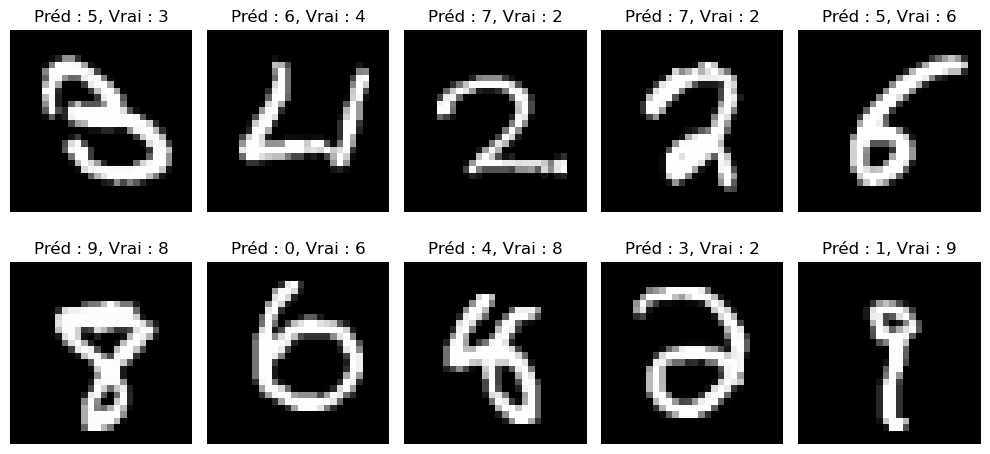

In [60]:
def visualize_errors(
    model2: nn.Module,
    test_loader: DataLoader,
    num_errors: int=10
)->None:
    """Affiche un certain nombre d’exemples mal classés par le modèle sur le jeu de test.

    Args:
        model2 (nn.Module): Modèle PyTorch à évaluer.
        test_loader (DataLoader): DataLoader contenant les données de test.
        num_errors (int, optional): Nombre d’erreurs à afficher. Defaults to 10.
    """
    model.eval()
    errors = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    errors.append((inputs[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
    # Afficher les erreurs
    plt.figure(figsize=(10, 5))
    for i, (image, pred, true) in enumerate(errors[:num_errors]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Préd : {pred}, Vrai : {true}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualiser les erreurs
visualize_errors(model, test_loader)
